In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import interpolate
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [2]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

### Compare the richness-based cluster finder to their best-fit model $\Delta\Sigma$ profiles

#### DSigma profiles of HSC massive galaxies

In [4]:
# DeltaSigma profiles of HSC massive galaxies
topn_massive = pickle.load(open(os.path.join(res_dir, 'topn_galaxies_sum.pkl'), 'rb'))

# DeltaSigma profiles of redMaPPer and CAMIRA clusters
topn_cluster = pickle.load(open(os.path.join(res_dir, 'topn_clusters_cen_sum.pkl'), 'rb'))

# For clusters, but using both central and satellite galaxies
topn_cluster_all = pickle.load(open(os.path.join(res_dir, 'topn_clusters_sum.pkl'), 'rb'))

#### DSigma profiles of mock galaxies

In [5]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

#### Halo mass distributions

In [6]:
sim_mhalo = Table.read(os.path.join(sim_dir, 'sim_merge_mhalo_hist.fits'))

In [7]:
dsig_cmp = topn_cluster['cam_s16a_n_mem'][:3]
label_cmp = r'$\rm CAMIRA$'
sub_cmp = r'{\rm CAM}'

dsig_ref = topn_cluster['redm_hsc_lambda'][:3]
label_ref = r'$\rm redMaPPer$'
sub_ref = r'{\rm redM}'

<ipython-input-11-4e711d77842a>:24: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


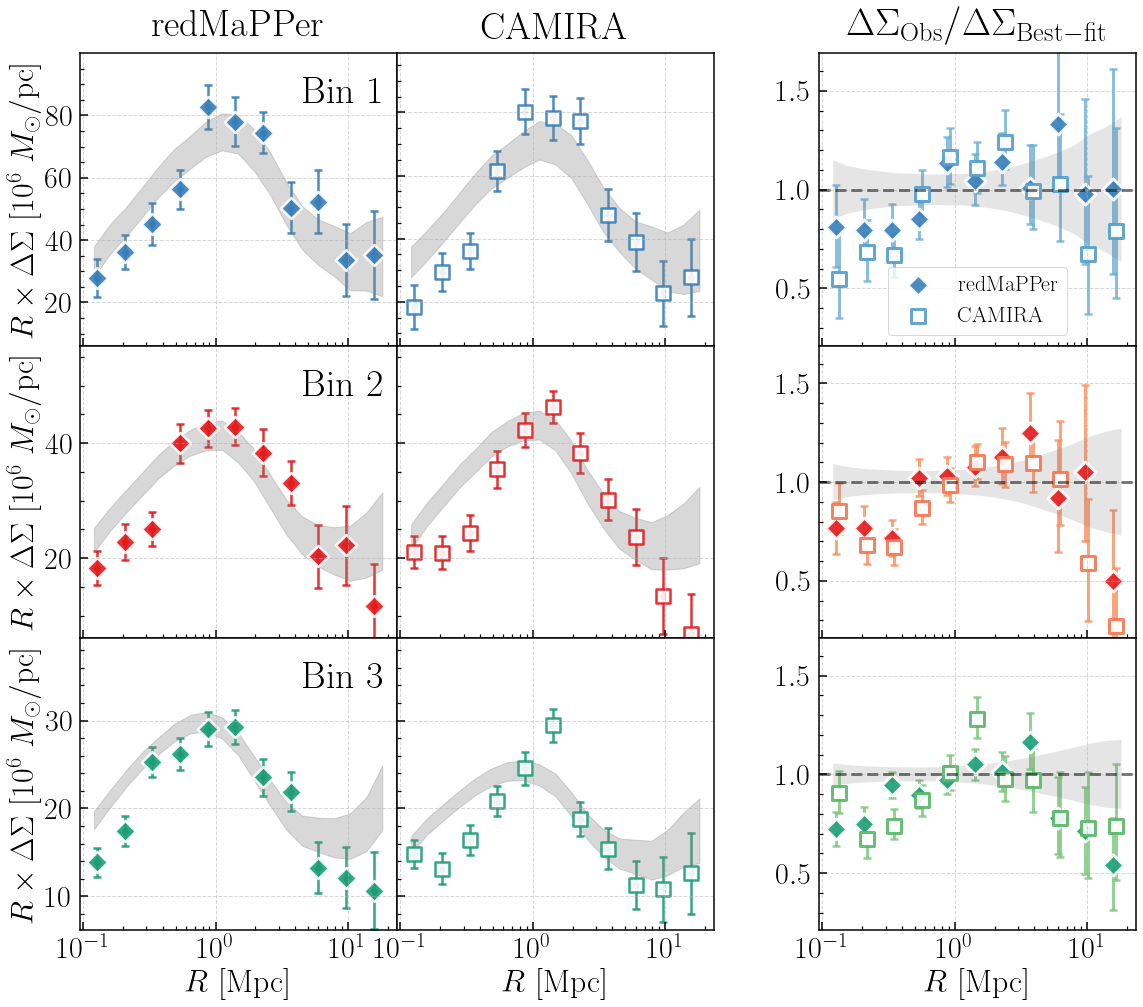

In [12]:
fig = compare_richness_model(
    dsig_ref, dsig_cmp, sim_dsig, sim_mhalo, sig_type='bt', compare_to_model=True,
    label_ref=label_ref, label_cmp=label_cmp, sub_ref=sub_ref, sub_cmp=sub_cmp,
    marker_ref='D', marker_cmp='s', msize_ref=220, msize_cmp=220)

In [13]:
fig.savefig(os.path.join(fig_dir, 'fig_10.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_10.pdf'), dpi=120)

#### Compare to [50, 100] kpc outskirt mass 

<ipython-input-17-c27b98c6991c>:24: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)
<ipython-input-17-c27b98c6991c>:24: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


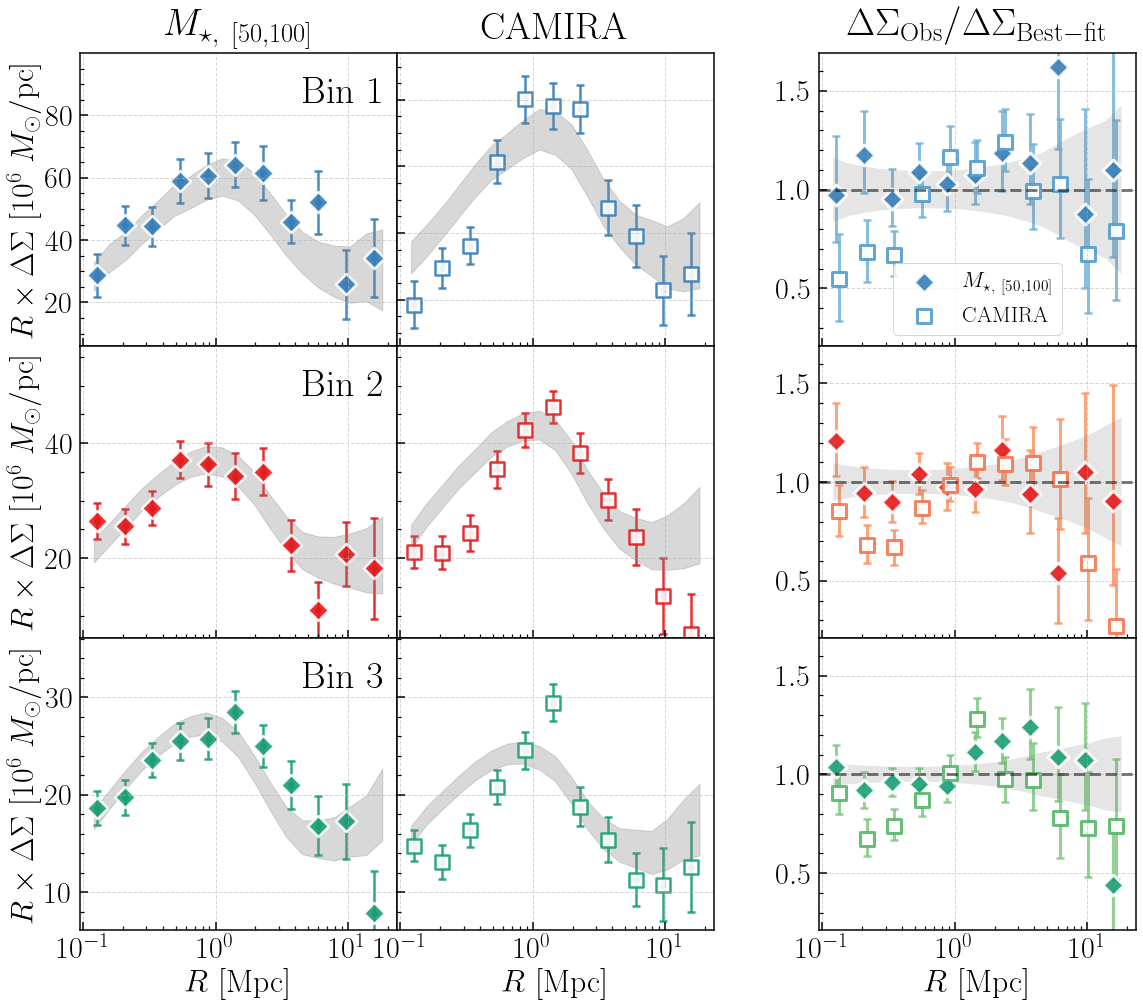

In [19]:
dsig_cmp = topn_cluster['cam_s16a_n_mem'][:3]
label_cmp = r'$\rm CAMIRA$'
sub_cmp = r'{\rm CAM}'

#dsig_ref = topn_cluster['redm_hsc_lambda'][:3]
#label_ref = r'$\rm redMaPPer$'
#sub_ref = r'{\rm redM}'

dsig_ref = topn_massive['logm_50_100'][:3]
label_ref = r'$M_{\star,\ [50, 100]}$'
sub_ref = r'{[50, 100]}'

fig = compare_richness_model(
    dsig_ref, dsig_cmp, sim_dsig, sim_mhalo, sig_type='bt', compare_to_model=True,
    label_ref=label_ref, label_cmp=label_cmp, sub_ref=sub_ref, sub_cmp=sub_cmp,
    marker_ref='D', marker_cmp='s', msize_ref=220, msize_cmp=220)

<ipython-input-17-c27b98c6991c>:24: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)
<ipython-input-17-c27b98c6991c>:24: RuntimeWarning: invalid value encountered in log10
  mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)


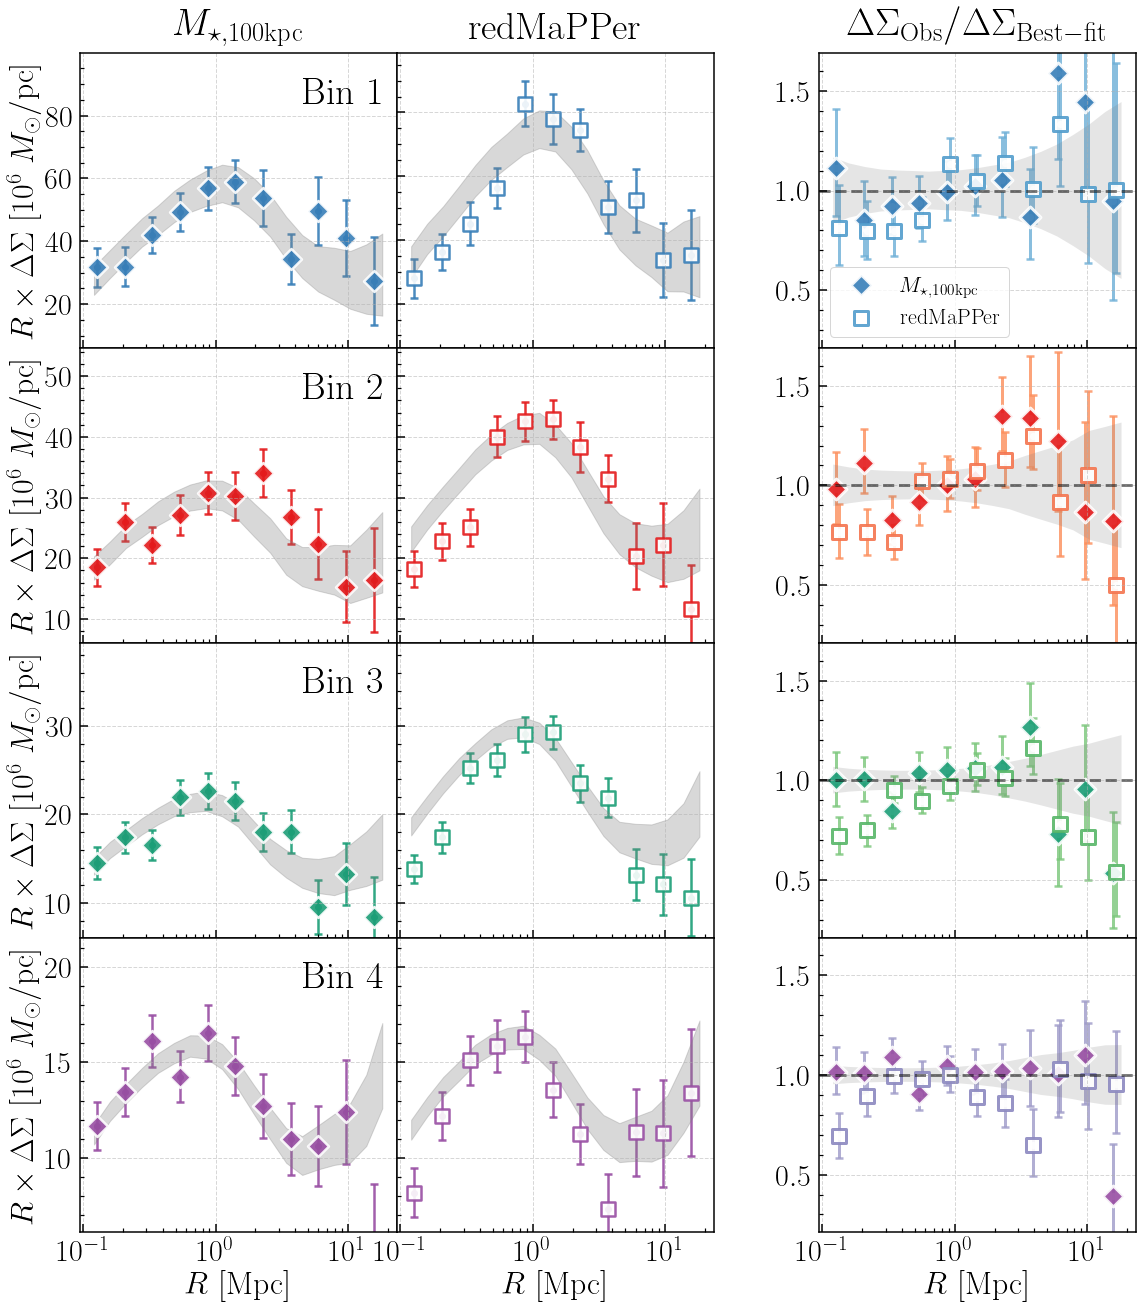

In [23]:
dsig_cmp = topn_cluster['redm_hsc_lambda']
label_cmp = r'$\rm redMaPPer$'
sub_cmp = r'{\rm redM}'

dsig_ref = topn_massive['logm_100']
label_ref = r'$M_{\star, 100 \rm kpc}$'
sub_ref = r'{[50, 100]}'

fig = compare_richness_model(
    dsig_ref, dsig_cmp, sim_dsig, sim_mhalo, sig_type='bt', compare_to_model=True,
    label_ref=label_ref, label_cmp=label_cmp, sub_ref=sub_ref, sub_cmp=sub_cmp,
    marker_ref='D', marker_cmp='s', msize_ref=220, msize_cmp=220)

In [17]:
# Modify the visual.compare_dsigma_profiles function

def compare_richness_model(dsig_ref, dsig_cmp, sim_dsig, sim_mhalo, sig_type='bt', compare_to_model=True,
                           label_ref=r'$\rm Ref$', label_cmp=r'$\rm Test$',
                           sub_ref=r'{\rm Ref}', sub_cmp=r'{\rm Test}',
                           cmap_list=None, color_bins=None, 
                           marker_ref='o', msize_ref=150,
                           marker_cmp='P', msize_cmp=180, 
                           show_best_cmp=False, 
                           dsig_cmp_2=None, label_cmp_2=r'$=rm Test 2$'):
    """Compare the Dsigma profiles."""

    def get_dsig_ratio(obs, ref, mod=None):
        """"""
        obs_rand = np.random.normal(
            loc=obs['dsigma'][0], scale=obs['dsig_err_{:s}'.format(sig_type)][0])

        if mod is not None:
            ref_rand = np.random.normal(
                loc=mod['dsig'], scale=(mod['dsig_err'] * err_factor))

            ref_inter = 10.0 ** (
                interpolate.interp1d(
                    mod['r_mpc'], np.log10(ref_rand), fill_value='extrapolate')(r_mpc_obs)
            )
            return obs_rand / ref_inter
        else:
            ref_rand = np.random.normal(
                loc=ref['dsigma'][0], scale=obs['dsig_err_{:s}'.format(sig_type)][0])
            return obs_rand / ref_rand


    # Color maps and bins
    if cmap_list is None:
        cmap_list = [
            palettable.colorbrewer.sequential.Blues_7_r,
            palettable.colorbrewer.sequential.OrRd_7_r,
            palettable.colorbrewer.sequential.YlGn_7_r,
            palettable.colorbrewer.sequential.Purples_7_r]

    if color_bins is None:
        color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

    # Radius bin of the observed DSigma profiles
    r_mpc_obs = dsig_ref.meta['r_mpc']

    # ---- Start the figure ---- #
    # Setup the figure
    n_col, n_bins = 3, len(dsig_ref)
    fig_y = int(4 * n_bins + 2)
    left, right = 0.07, 0.98
    if n_bins == 4:
        bottom, top = 0.05, 0.96
    elif n_bins == 3:
        bottom, top = 0.07, 0.94
    elif n_bins == 2:
        bottom, top = 0.11, 0.92
        
    x_space = 0.08
    x_size = (right - left - x_space * 1.05) / n_col
    y_size = (top - bottom) / n_bins
    
    fig = plt.figure(figsize=(16, fig_y))

    for bin_id in np.arange(len(dsig_ref)) + 1:
        # Setup the three columns
        ax1 = fig.add_axes([left, top - y_size * bin_id, x_size, y_size])
        ax2 = fig.add_axes([left + x_size, top - y_size * bin_id, x_size, y_size])
        ax3 = fig.add_axes([left + x_space + x_size * 2.04, top - y_size * bin_id, x_size, y_size])

        # Subplot title
        if bin_id == 1:
            ax1.set_title(label_ref, fontsize=38, pad=18)
            ax2.set_title(label_cmp, fontsize=38, pad=15)
            ax3.set_title(r'$\Delta\Sigma_{\rm Obs}/\Delta\Sigma_{\rm Best-fit}$', 
                          fontsize=38, pad=18)

        # Color map
        cmap, color = cmap_list[bin_id - 1], color_bins[bin_id - 1]

        # MDPL halo mass information for this bin
        sim_dsig_bin = sim_dsig[sim_dsig['bin'] == bin_id - 1]
        sim_mhalo_bin = sim_mhalo[sim_mhalo['number_density_bin'] == bin_id - 1]

        # DSigma result for this bin
        dsig_ref_bin = dsig_ref[dsig_ref['bin_id'] == bin_id]
        dsig_cmp_bin = dsig_cmp[dsig_cmp['bin_id'] == bin_id]

        # Best fit DSigma profiles
        dsig_ref_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_ref_bin['sig_med_{:s}'.format(sig_type)]))]
        dsig_cmp_best = sim_dsig_bin[
            np.argmin(
                np.abs(sim_dsig_bin['scatter'] - dsig_cmp_bin['sig_med_{:s}'.format(sig_type)]))]

        if dsig_ref_bin['sig_med_{:s}'.format(sig_type)] < 0.6:
            err_factor = 5.
        else:
            err_factor = 4.

        # Interpolated the reference model profile
        ref_model_inter = 10.0 ** (
            interpolate.interp1d(
                dsig_ref_best['r_mpc'], np.log10(dsig_ref_best['dsig']),
                fill_value='extrapolate')(r_mpc_obs)
        )
        
        cmp_model_inter = 10.0 ** (
            interpolate.interp1d(
                dsig_cmp_best['r_mpc'], np.log10(dsig_cmp_best['dsig']),
                fill_value='extrapolate')(r_mpc_obs)
        )

        ratio_sample = [
            get_dsig_ratio(
                dsig_cmp_bin, dsig_ref_bin, mod=dsig_cmp_best) for i in np.arange(2000)]
        ratio_cmp = dsig_cmp_bin['dsigma'][0] / cmp_model_inter
        ratio_cmp_err_low = ratio_cmp - np.nanpercentile(ratio_sample, 16, axis=0)
        ratio_cmp_err_upp = np.nanpercentile(ratio_sample, 84, axis=0) - ratio_cmp
        
        ratio_sample = [
            get_dsig_ratio(
                dsig_ref_bin, dsig_cmp_bin, mod=dsig_ref_best) for i in np.arange(2000)]
        ratio_ref = dsig_ref_bin['dsigma'][0] / ref_model_inter
        ratio_ref_err_low = ratio_ref - np.nanpercentile(ratio_sample, 16, axis=0)
        ratio_ref_err_upp = np.nanpercentile(ratio_sample, 84, axis=0) - ratio_ref
        
        # Halo mass distribution from model
        if bin_id == 1:
            n_bins = 8
        elif bin_id == 2:
            n_bins = 4
        else:
            n_bins = 3

        mvir_true, hist_true, mvir_avg_true = catalog.rebin_mhalo_hist(
            sim_mhalo_bin, bin_id - 1, 0.0, n_bin=n_bins)

        mvir_ref, hist_ref, mvir_avg_ref = catalog.rebin_mhalo_hist(
            sim_mhalo_bin, bin_id - 1, dsig_ref_bin['sig_med_{:s}'.format(sig_type)], n_bin=20)
        mvir_cmp, hist_cmp, mvir_avg_cmp = catalog.rebin_mhalo_hist(
            sim_mhalo_bin, bin_id - 1, dsig_cmp_bin['sig_med_{:s}'.format(sig_type)], n_bin=20)

        # ----- Plot 1: R x DSigma plot ----- #
        ax1.set_xscale("log", nonpositive='clip')

        ax1.fill_between(
            dsig_ref_best['r_mpc'],
            dsig_ref_best['r_mpc'] * (
                dsig_ref_best['dsig'] - dsig_ref_best['dsig_err'] * err_factor),
            dsig_ref_best['r_mpc'] * (
                dsig_ref_best['dsig'] + dsig_ref_best['dsig_err'] * err_factor),
            alpha=0.3, edgecolor='grey', linewidth=1.0,
            label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

        ax1.errorbar(
            r_mpc_obs,
            r_mpc_obs * dsig_ref_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_ref_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5,
            label='__no_label__', fmt='o', zorder=0)
        ax1.scatter(
            r_mpc_obs,
            r_mpc_obs * dsig_ref_bin['dsigma'][0],
            s=msize_ref, alpha=0.9, facecolor=color, edgecolor='w', marker=marker_ref, 
            linewidth=2.5, label=label_ref)

        y_max = np.max(
            [np.max(dsig_ref_best['r_mpc'] * dsig_ref_best['dsig']), 
             np.max(dsig_cmp_best['r_mpc'] * dsig_cmp_best['dsig'])]) * 1.32
        
        if bin_id == 1:
            ax1.set_ylim(6.1, 99.9)
        else:
            ax1.set_ylim(6.1, y_max)

        # Bin ID
        _ = ax1.text(
            0.70, 0.83, r'$\rm Bin\ {:1d}$'.format(bin_id), fontsize=38, transform=ax1.transAxes)
        
        if bin_id == len(dsig_ref):
            _ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax1.set_xticklabels([])
        _ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=32)
        
        
        # ----- Plot 2: Ratio of DSigma plot ----- #
        ax2.set_xscale("log", nonpositive='clip')
        
        ax2.fill_between(
            dsig_cmp_best['r_mpc'],
            dsig_cmp_best['r_mpc'] * (
                dsig_cmp_best['dsig'] - dsig_cmp_best['dsig_err'] * err_factor),
            dsig_cmp_best['r_mpc'] * (
                dsig_cmp_best['dsig'] + dsig_cmp_best['dsig_err'] * err_factor),
            alpha=0.3, edgecolor='grey', linewidth=1.0,
            label=r'__no_label__', facecolor='grey', linestyle='-', rasterized=True)

        ax2.errorbar(
            r_mpc_obs,
            r_mpc_obs * dsig_cmp_bin['dsigma'][0],
            yerr=(r_mpc_obs * dsig_cmp_bin['dsig_err_{:s}'.format(sig_type)][0]),
            ecolor=color, color=color, alpha=0.9, capsize=4, capthick=2.5, elinewidth=2.5,
            label='__no_label__', fmt='o', zorder=0)
        ax2.scatter(
            r_mpc_obs,
            r_mpc_obs * dsig_cmp_bin['dsigma'][0],
            s=msize_cmp, alpha=0.9, facecolor='w', edgecolor=color, marker=marker_cmp, 
            linewidth=2.5, label=label_cmp)
        
        y_max = np.max(
            [np.max(dsig_ref_best['r_mpc'] * dsig_ref_best['dsig']), 
             np.max(dsig_cmp_best['r_mpc'] * dsig_cmp_best['dsig'])]) * 1.32
        ax2.set_ylim(6.1, y_max)

        if bin_id == len(dsig_ref):
            _ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax2.set_xticklabels([])
        
        ax2.set_yticklabels([])


        # ----- Plot 2: Ratio of DSigma plot ----- #
        ax3.set_xscale("log", nonpositive='clip')

        ax3.axhline(
            1.0, linewidth=3.0, alpha=0.5, color='k', linestyle='--', label='__no_label__', )

        # Uncertainty of the model
        ax3.fill_between(
            dsig_ref_best['r_mpc'],
            1.0 - (dsig_ref_best['dsig_err'] * err_factor / dsig_ref_best['dsig']),
            1.0 + (dsig_ref_best['dsig_err'] * err_factor / dsig_ref_best['dsig']),
            alpha=0.2, edgecolor='none', linewidth=1.0, label='__no_label__',
            facecolor='grey', rasterized=True)

        ax3.errorbar(
            r_mpc_obs, ratio_ref, yerr=[ratio_ref_err_low, ratio_ref_err_upp],
            ecolor=cmap.mpl_colormap(0.5), color='w', alpha=0.8, capsize=4, capthick=2.5,
            elinewidth=3.0, label='__no_label__', fmt='o', zorder=0)
        ax3.scatter(
            r_mpc_obs, ratio_ref,
            s=msize_ref, alpha=0.9, facecolor=color, edgecolor='w',
            marker=marker_ref, linewidth=3.0, label=label_ref)
        
        ax3.errorbar(
            r_mpc_obs * 1.05, ratio_cmp, yerr=[ratio_cmp_err_low, ratio_cmp_err_upp],
            ecolor=cmap.mpl_colormap(0.5), color='w', alpha=0.8, capsize=4, capthick=2.5,
            elinewidth=3.0, label='__no_label__', fmt='o', zorder=0)
        ax3.scatter(
            r_mpc_obs * 1.05, ratio_cmp,
            s=msize_cmp, alpha=0.9, facecolor='w', edgecolor=cmap.mpl_colormap(0.4),
            marker=marker_cmp, linewidth=3.0, label=label_cmp)
        
        ax3.set_ylim(0.21, 1.69)

        if np.max(ratio_cmp) < 1.2:
            y_pos = 0.85
        else:
            y_pos = 0.15

        if bin_id == 1:
            ax3.legend(loc='best', fontsize=22)

        if bin_id == len(dsig_ref):
            _ = ax3.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=32)
        else:
            ax3.set_xticklabels([])
            
        #_ = ax3.set_ylabel(r'$\Delta\Sigma_{\rm Richness}/\Delta\Sigma_{[50,150]}$', fontsize=30)
        
        for tick in ax1.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax1.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

        for tick in ax2.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax2.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

        for tick in ax3.xaxis.get_major_ticks():
            tick.label.set_fontsize(30)
        for tick in ax3.yaxis.get_major_ticks():
            tick.label.set_fontsize(30)

    return fig